# Deep Learning using PyTorch

In [1]:
from glob import glob
import json
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

# importing PyTorch
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

# torchmetrics: computing metrics to evaluate performance
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary

# pytorch_lightning: simplifies specification and fitting
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# ensuring reproducability
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

# importing datasets
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

Seed set to 0


# Single Layer Network

1. Importing the data

In [2]:
# data
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

# model matrix
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy() # converts dataframe to numpy array
Y = Hitters['Salary'].to_numpy()

# generating a test and training set
(X_train, X_test,
 Y_train, Y_test) = train_test_split(X,
                                     Y,
                                     test_size=1/3,
                                     random_state=1)

1. Fitting Linear Regression

In [5]:
# fitting Linear Regression
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
print("Absolute error:", np.abs(Yhat_test - Y_test).mean())

Absolute error: 259.71528833146294


2. Fitting Lasso

In [7]:
# fitting the Lasso
# normalization
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
# creating the pipeline
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])
# creating a grid for lambda
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'lasso__alpha': np.exp(np.linspace(0, np.log(0.01), 100))
             * lam_max}
# get the best value for lambda
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(standard_lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
# test on the best value of lambda
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
print("Absolute error:", np.fabs(Yhat_test - Y_test).mean())

Absolute error: 235.6754837478029


Both are only for one train/test split, so their results may vary a lot.

3. Building the Neural Network

In PyTorch, you have to define a new class for your model.

In [ ]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential( # creating one layer
            nn.Linear(input_size, 50), # creating 1000 nodes:
            # 950 for 19 features mapped onto 50 dimensions each
            # 50 times an intercept / bias, each for one dimension
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

Creating the model

In [9]:
hit_model = HittersModel(X.shape[1])

Getting info about the network

In [10]:
summary(hit_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

Transforming the data to work with the neural network into a `tensor`, a basic datatype. Torch works with 32bit instead of 64bit floats.

In [11]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

Getting the reasonable amount of "workers" (a separate process that loads data into memory while the main training process runs in parallel).

In [12]:
max_num_workers = rec_num_workers()

Next, we iplement a DataLoader() - or, as here, we use an easier way of doing it with the corresponding ISLP SimpleDataModule().

In [13]:
hit_dm = SimpleDataModule(hit_train, # training data
                          hit_test, # validation data to estimate the error
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test) # test error at the end
                          # (in this case the same as the validation error)

Next, this is to record the value of the loss function (=error) and additional metrics after each epoch. SimpleModule.regression() automatically uses the squared error. Mean Absolute Error is in this case also to be tracked. The results are logged and saved to csv using CSVLogger().

In [15]:
hit_module = SimpleModule.regression(hit_model,
                           metrics={'mae':MeanAbsoluteError()})
hit_logger = CSVLogger('logs', name='hitters')

Now on to training the model:

In [18]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\lbrau\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory logs\hitters\version_0\checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 120.58it/s, v_num=0]           

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 120.58it/s, v_num=0]


Getting the results of the training:

In [19]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 55.53it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              104042.78125
        test_mae            207.05848693847656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104042.78125, 'test_mae': 207.05848693847656}]

# Visualizing the results

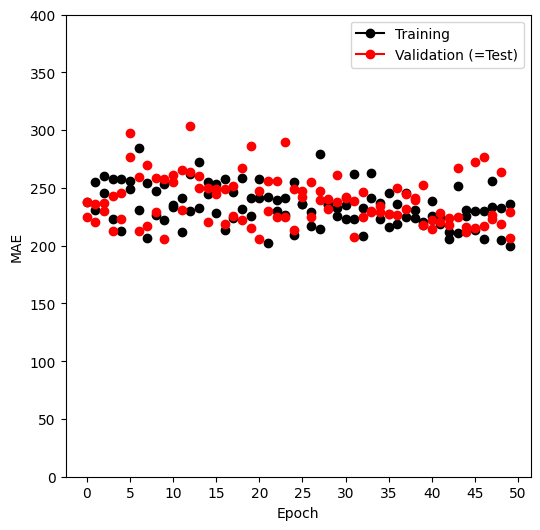

In [20]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

# creating a generic function
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

# plotting
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int))

Calling eval() tells torch the model is fitted and done.

In [21]:
hit_model.eval() 
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(207.0585, grad_fn=<MeanBackward0>)

### Cleanup
In setting up our data module, we had initiated
several worker processes that will remain running.
We delete all references to the torch objects to ensure these processes
will be killed.

In [22]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

# Single Layer Network

Getting the data

In [23]:
(mnist_train, 
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 292kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Creating a data module

In [25]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)

Getting to know the data:

In [26]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


Each batch: 256 images, 1 grey-scale channel, 28x28 pixels.

Specifying the NN:

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10)) # 10: nr of classes in the MNIST data
    def forward(self, x):
        return self._forward(x)

Getting to know the model:

In [29]:
mnist_model = MNISTModel()
print(mnist_model(X_).size()) # outputs 10 class probabilities for 256 examples
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

torch.Size([256, 10])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

The same as above: Loss function, additional metrics, Logger. Then fitting the model.

In [30]:
mnist_module = SimpleModule.classification(mnist_model,
                                           num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


Visualizing:

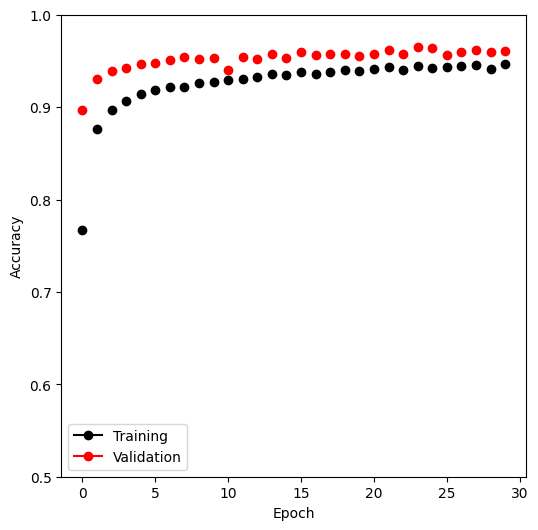

In [31]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int))

In [32]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9634000062942505
        test_loss           0.15775413811206818
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15775413811206818, 'test_accuracy': 0.9634000062942505}]

Fitting LDA with a Neural Network by omitting the hidden layers:

In [33]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      enable_progress_bar=False,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9196000099182129
        test_loss            0.325993150472641
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.325993150472641, 'test_accuracy': 0.9196000099182129}]

In [34]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

# Convolutional Neural Networks (CNNs)